# Xylan degradation

In this notebook we will explore xylan production in Bascillus subtilis 168

In [2]:
from spamdfba import toolkit as tk
import cobra
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import os
import warnings
import rich
import multiprocessing as mp
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2024-08-13 11:44:23,037	INFO worker.py:1724 -- Started a local Ray instance.


First we have to load the metabolic model of Bascillus subtilis 168, which is available in the BiGG database. Run below to download the model.


In [ ]:
# !wget http://bigg.ucsd.edu/static/models/iYO844.json.gz
#! gzip -d iYO844.json.gz

In [ ]:
from collections import Counter

Now let's load the model.

In [ ]:
bacillus_model=cobra.io.load_json_model('./iYO844.json')

We have two genes known for xylan breakdown in Bascillus subtilis 168:

Endo-1,4-beta-xylanase A:P18429

Beta-xylosidase: P94489

In [ ]:
P18429="MFKFKKNFLVGLSAALMSISLFSATASAASTDYWQNWTDGGGIVNAVNGSGGNYSVNWSNTGNFVVGKGWTTGSPFRTINYNAGVWAPNGNGYLTLYGWTRSPLIEYYVVDSWGTYRPTGTYKGTVKSDGGTYDIYTTTRYNAPSIDGDRTTFTQYWSVRQSKRPTGSNATITFSNHVNAWKSHGMNLGSNWAYQVMATEGYQSSGSSNVTVW"
P94489="MKITNPVLKGFNPDPSICRAGEDYYIAVSTFEWFPGVQIHHSKDLVNWHLVAHPLQRVSQLDMKGNPNSGGVWAPCLSYSDGKFWLIYTDVKVVDGAWKDCHNYLVTCETINGDWSEPIKLNSSGFDASLFHDTDGKKYLLNMLWDHRIDRHSFGGIVIQEYSDKEQKLIGKPKVIFEGTDRKLTEAPHLYHIGNYYYLLTAEGGTRYEHAATIARSANIEGPYEVHPDNPILTSWHDPGNPLQKCGHASIVQTHTDEWYLAHLTGRPIHPDDDSIFQQRGYCPLGRETAIQKLYWKDEWPYVVGGKEGSLEVDAPSIPETIFEATYPEVDEFEDSTLNINFQTLRIPFTNELGSLTQAPNHLRLFGHESLTSTFTQAFVARRWQSLHFEAETAVEFYPENFQQAAGLVNYYNTENWTALQVTHDEELGRILELTICDNFSFSQPLNNKIVIPREVKYVYLRVNIEKDKYYYFYSFNKEDWHKIDIALESKKLSDDYIRGGGFFTGAFVGMQCQDTSGNHIPADFRYFRYKEK"

In [ ]:
def get_protein_production_reaction(protein_name:str,protein_sequence:str,atp_per_aa:float=4.2)->cobra.Reaction:
    aa_name_conversion = {
        "A": "ala__L_c",
        "R": "arg__L_c",
        "N": "asn__L_c",
        "D": "asp__L_c",
        "C": "cys__L_c",
        "Q": "gln__L_c",
        "E": "glu__L_c",
        "G": "gly_c",
        "H": "his__L_c",
        "I": "ile__L_c",
        "L": "leu__L_c",
        "K": "lys__L_c",
        "M": "met__L_c",
        "F": "phe__L_c",
        "P": "pro__L_c",
        "S": "ser__L_c",
        "T": "thr__L_c",
        "W": "trp__L_c",
        "Y": "tyr__L_c",
        "V": "val__L_c",
    }
    
    counts=dict([(aa_name_conversion[i],val) for i,val in Counter(protein_sequence).items()])
    counts["atp_c"]=len(protein_sequence)*atp_per_aa
    sum_=sum(counts.values())
    reaction=cobra.Reaction(protein_name+"_production")
    for i,val in counts.items():
        reaction.add_metabolites({cobra.Metabolite(i,compartment="c"):-val/sum_})
        
    reaction.add_metabolites({cobra.Metabolite(protein_name,compartment="e"):1/sum_})
    reaction.add_metabolites({cobra.Metabolite("adp_c",compartment="c"):counts["atp_c"]/sum_})
    reaction.add_metabolites({cobra.Metabolite("pi_c",compartment="c"):counts["atp_c"]/sum_})
    reaction.lower_bound=0
    reaction.upper_bound=100
    ex_reaction=cobra.Reaction(protein_name+"_export")
    ex_reaction.add_metabolites({reaction.products[0]:-1})
    return [reaction,ex_reaction]
    
    

In [ ]:
get_protein_production_reaction("xylanase",P18429)
get_protein_production_reaction("xylosidase",P94489)

In [ ]:
bacillus_model.add_reactions(get_protein_production_reaction("xylanase",P18429))
bacillus_model.add_reactions(get_protein_production_reaction("xylosidase",P94489))

In [ ]:
bacillus_model.biomass_ind=bacillus_model.reactions.index("BIOMASS_BS_10")
agent1=tk.Agent("Bacllus_agent1",
                model=bacillus_model,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['Bacllus_agent1' ,"xyl__D_e", 'Xylan'],
                actions=["xylanase_production","xylosidase_production"],
                gamma=1,
                )

agents=[agent1]

In [ ]:
ic={i[3:]:bacillus_model.medium[i] for i in bacillus_model.medium}

In [ ]:
del ic["glc__D_e"]

In [ ]:
constants=list(ic.keys())

In [ ]:
def general_kinetics(a,b):
    return 100*a*b/(1+a)  

In [ ]:
ic.update({"xyl__D_e":10,"Bacllus_agent1":0.01,"Xylan":10})
env_1=tk.Environment(name="Bacillus_168_Xylan",
                    agents=agents,
                    dilution_rate=0.00000001,
                    initial_condition=ic,
                    inlet_conditions={},
                    extracellular_reactions=[
                    {"reaction":{
                      "Xylose_oligo":10,
                      "Xylan":-0.1,},
                      "kinetics": (general_kinetics,("Xylan","xylanase"))},                                                                  
                    {"reaction":{
                      "Xylose_oligo":-1,
                      "xyl__D_e":5,},
                      "kinetics": (general_kinetics,("Xylose_oligo","xylosidase"))},
                                           ],
                    constant=constants,
                     dt=0.1,
                     number_of_batches=5000,
                     episodes_per_batch=8,)

In [ ]:
sim_1=tk.Simulation(name=env_1.name,
                  env=env_1,
                  save_dir="./Results/",
                  )

In [ ]:
env_1.agents[0].model.solver="gurobi"

In [ ]:
sim_1.run()

In [238]:
fig=make_subplots(rows=1,cols=2,subplot_titles=("Cell Concentration","Xylose Concentration"))

In [239]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_180_obs.pkl","rb") as f:
    data=pickle.load(f)

In [240]:
data_avg=data["Bacllus_agent1"].numpy().reshape(8,100,4,order="C").mean(axis=0)
data_min=data["Bacllus_agent1"].numpy().reshape(8,100,4,order="C").min(axis=0)
data_max=data["Bacllus_agent1"].numpy().reshape(8,100,4,order="C").max(axis=0)

In [241]:
data_avg=pd.DataFrame(data_avg,columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])
data_min=pd.DataFrame(data_min,columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])
data_max=pd.DataFrame(data_max,columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])

In [243]:
fig.add_trace(
              go.Scatter(x=data_avg.index,
                         y=data_avg["Bacllus_agent1"],
                         name="Trained Agent",
                         line=dict(color="rgba(0,100,80)",width=2)
                         ),
            row=1,col=1)

fig.add_trace(
              go.Scatter(x=data_max.index.to_list()+data_min.index[::-1].to_list(),
                         y=data_max["Bacllus_agent1"].to_list()+data_min["Bacllus_agent1"].to_list()[::-1],
                         fill="toself",fillcolor="rgba(0,100,80,0.2)",
                         line=dict(color="rgba(255,255,255,0)"),
                         showlegend=False)
            ,row=1,col=1)

fig.add_trace(go.Scatter(x=data_avg.index,y=data_avg["xyl__D_e"],showlegend=False,line=dict(color="rgba(0,100,80)")),row=1,col=2)
fig.add_trace(go.Scatter(x=data_max.index.to_list()+data_min.index[::-1].to_list(),
                            y=data_max["xyl__D_e"].to_list()+data_min["xyl__D_e"].to_list()[::-1],
                            fill="toself",fillcolor="rgba(0,100,80,0.2)",line=dict(color="rgba(255,255,255,0)"),
                            showlegend=False),row=1,col=2)

fig.show()

In [143]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_0_obs.pkl","rb") as f:
    data=pickle.load(f)

In [144]:
data_avg=data["Bacllus_agent1"].numpy().reshape(8,100,4,order="C").mean(axis=0)
data_min=data["Bacllus_agent1"].numpy().reshape(8,100,4,order="C").min(axis=0)
data_max=data["Bacllus_agent1"].numpy().reshape(8,100,4,order="C").max(axis=0)

In [145]:
data_avg=pd.DataFrame(data_avg,columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])
data_min=pd.DataFrame(data_min,columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])
data_max=pd.DataFrame(data_max,columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])

In [146]:
fig.add_trace(go.Scatter(x=data_avg.index,y=data_avg["Bacllus_agent1"],mode="lines",name="No Xylanase Agent (DFBA)",line=dict(dash="dash")))
fig.add_trace(go.Scatter(x=data_max.index.to_list()+data_min.index[::-1].to_list(),
                            y=data_max["Bacllus_agent1"].to_list()+data_min["Bacllus_agent1"].to_list()[::-1],
                            fill="toself",fillcolor="rgba(0,100,80,0.2)",line=dict(color="rgba(255,255,255,0)"),
                            showlegend=False))

fig.update_layout(font=dict(size=18,family="Times New Roman"),)

In [322]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_1000_obs.pkl","rb") as f:
    data=pickle.load(f)

In [323]:
data=pd.DataFrame(data["Bacllus_agent1"].numpy(),columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])

In [324]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data.index,y=data["xyl__D_e"],mode="lines",name="Xylose"))
fig.add_trace(go.Scatter(x=data.index,y=data["Xylan"],mode="lines",name="Xylan"))
fig.add_trace(go.Scatter(x=data.index,y=data["Bacllus_agent1"],mode="lines",name="Bacillus"))
fig.show()

In [443]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_1560_obs.pkl","rb") as f:
    obs=pickle.load(f)
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_0_acts.pkl","rb") as f:
    acts=pickle.load(f)
# with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_0.pkl","rb") as f:
#     env=pickle.load(f)
    


In [32]:
acts

{'Bacllus_agent1': tensor([[-4.1944,  8.4915],
         [-4.1308,  8.7951],
         [-4.0644,  9.2012],
         ...,
         [ 0.2657,  0.2293],
         [-0.3025,  0.2059],
         [-0.1568,  0.3713]])}

<Axes: >

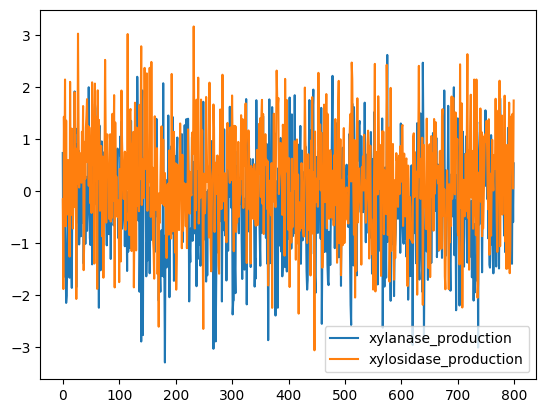

In [444]:
pd.DataFrame(acts["Bacllus_agent1"],columns=["xylanase_production","xylosidase_production"]).plot()

In [ ]:
with open("/Users/parsaghadermarzi/Desktop/Academics/Projects/SPAM-DFBA/examples/Results/Bacillus_168_Xylan/Bacillus_168_Xylan_200.pkl","rb") as f:
    env=pickle.load(f)

In [ ]:
from spamdfba import toolkit as tk

In [ ]:
env.initial_condition[232]=1

In [ ]:
obs=tk.rollout(env)

In [ ]:
data=pd.DataFrame(obs[0]["Bacllus_agent1"],columns=['Bacllus_agent1' ,"xyl__D_e", 'Xylan','time_left'])

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data.index,y=data["xyl__D_e"],mode="lines",name="Xylose"))
fig.add_trace(go.Scatter(x=data.index,y=data["Xylan"],mode="lines",name="Xylan"))
fig.add_trace(go.Scatter(x=data.index,y=data["Bacllus_agent1"],mode="lines",name="Bacillus"))
fig.show()